# Airline Sentiment Analysis using Bayesian Models

This analysis explores Twitter sentiment data for various airlines using two Bayesian approaches:

1. A basic model that estimates overall sentiment probabilities
1. A hierarchical model that accounts for airline-specific differences

Note on interpretation:

- Sentiment categories are: Negative (0), Neutral (1), Positive (2)
- Theta parameters represent probabilities of each sentiment category
- Results are presented with 95% credible intervals

# Data Loading and Initial Exploration

Load the airline sentiment dataset and examine its structure, missing values, and basic statistics. Include visualizations of sentiment distribution and airline distribution.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

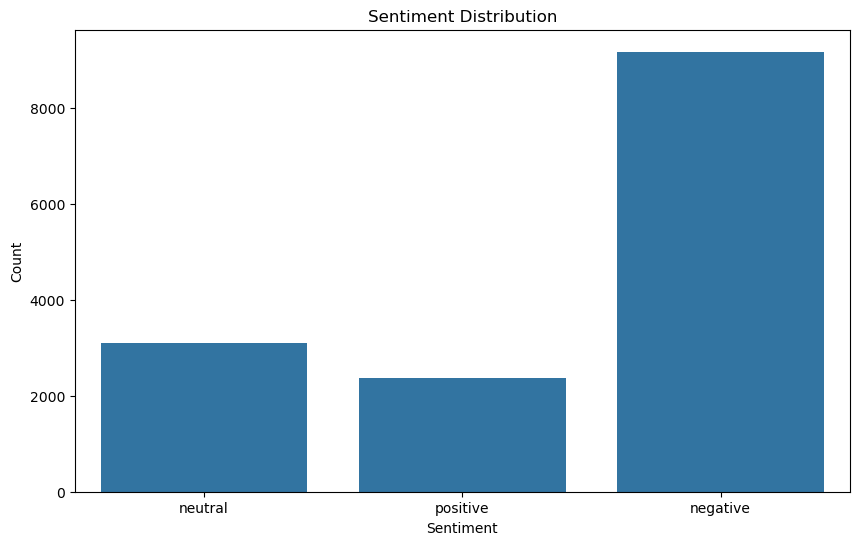

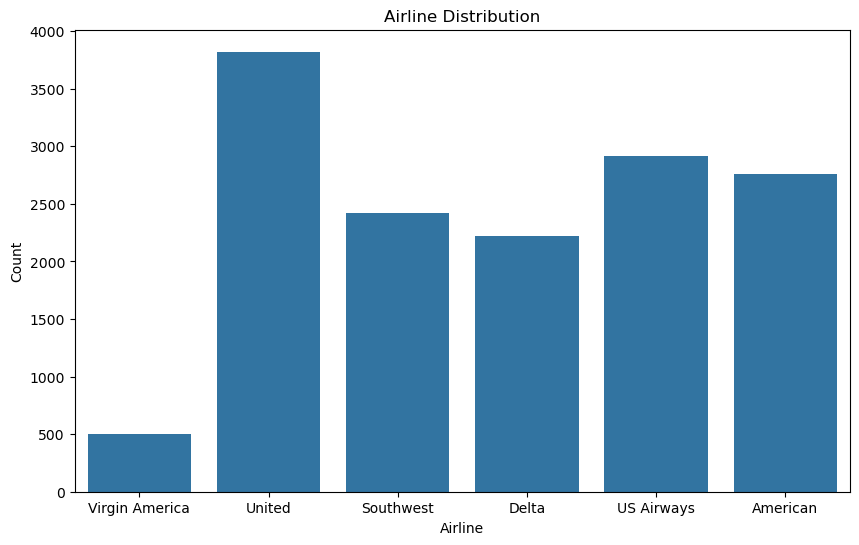

In [14]:
# Import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv("data/Tweets.csv")

# Show basic information about the dataset
df.info()
df.head()

# Check for missing values
missing_values = df.isnull().sum()
print(missing_values)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='airline_sentiment', data=df)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

# Visualize airline distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='airline', data=df)
plt.title("Airline Distribution")
plt.xlabel("Airline")
plt.ylabel("Count")
plt.show()

## Data Preprocessing and Sentiment Analysis

Clean the data, handle missing values, and prepare it for Bayesian modeling. Map sentiment categories to numerical values and create airline-specific datasets.

In [15]:
# Data Preprocessing and Sentiment Analysis

# Drop rows with missing sentiment values
df = df.dropna(subset=['airline_sentiment'])

# Map sentiment categories to numerical values (required for PyMC's categorical distribution)
sentiment_map = {'negative': 0, 'neutral': 1, 'positive': 2}
df['sentiment_numeric'] = df['airline_sentiment'].map(sentiment_map)

# Create airline-specific datasets
airlines = df['airline'].unique()
airline_data = {
    airline: {
        'counts': df[df['airline'] == airline]['sentiment_numeric'].value_counts().reindex([0, 1, 2], fill_value=0).values,
        'total': len(df[df['airline'] == airline])
    }
    for airline in airlines
}

# Display the first few rows of the cleaned dataset
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,sentiment_numeric
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),1
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),2
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),1
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),0
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),0


## Basic Bayesian Model

Implement a simple Dirichlet-Categorical model to estimate overall sentiment probabilities across all airlines. Include prior selection and posterior analysis.

Initializing NUTS using jitter+adapt_diag...


Number of tweets per sentiment category (negative, neutral, positive): [9178 3099 2363]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 10 seconds.


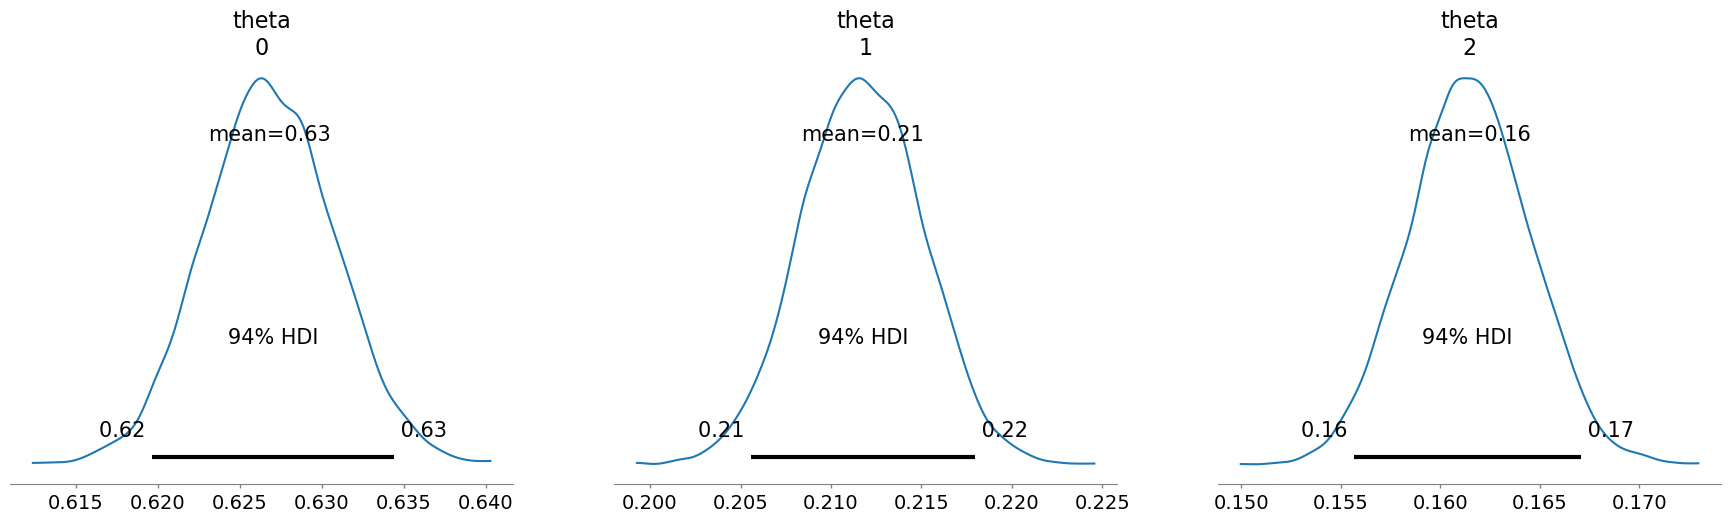

In [16]:
import pymc as pm
import numpy as np
import arviz as az

# Count the number of tweets in each sentiment category
sentiment_frequencies = df['airline_sentiment'].value_counts().sort_index().values
print(f"Number of tweets per sentiment category (negative, neutral, positive): {sentiment_frequencies}")

# Set a prior: symmetric Dirichlet prior
alpha_prior = np.array([1, 1, 1])  # Weak prior

# Define the model
with pm.Model() as basic_model:
    # Dirichlet prior
    theta = pm.Dirichlet("theta", a=alpha_prior)
    
    # Observed categorical data
    observed = pm.Categorical("observed", p=theta, observed=np.repeat([0, 1, 2], obs_counts))
    
    # Inference
    basic_trace = pm.sample(2000, return_inferencedata=True)

# Summary of posterior
az.summary(basic_trace, var_names=["theta"])

# Plot posterior distributions
az.plot_posterior(basic_trace, var_names=["theta"])
plt.show()

## Hierarchical Bayesian Model

Develop a hierarchical model to account for airline-specific sentiment distributions, using a population-level prior and airline-specific parameters.

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_population, concentration, theta]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 32 seconds.


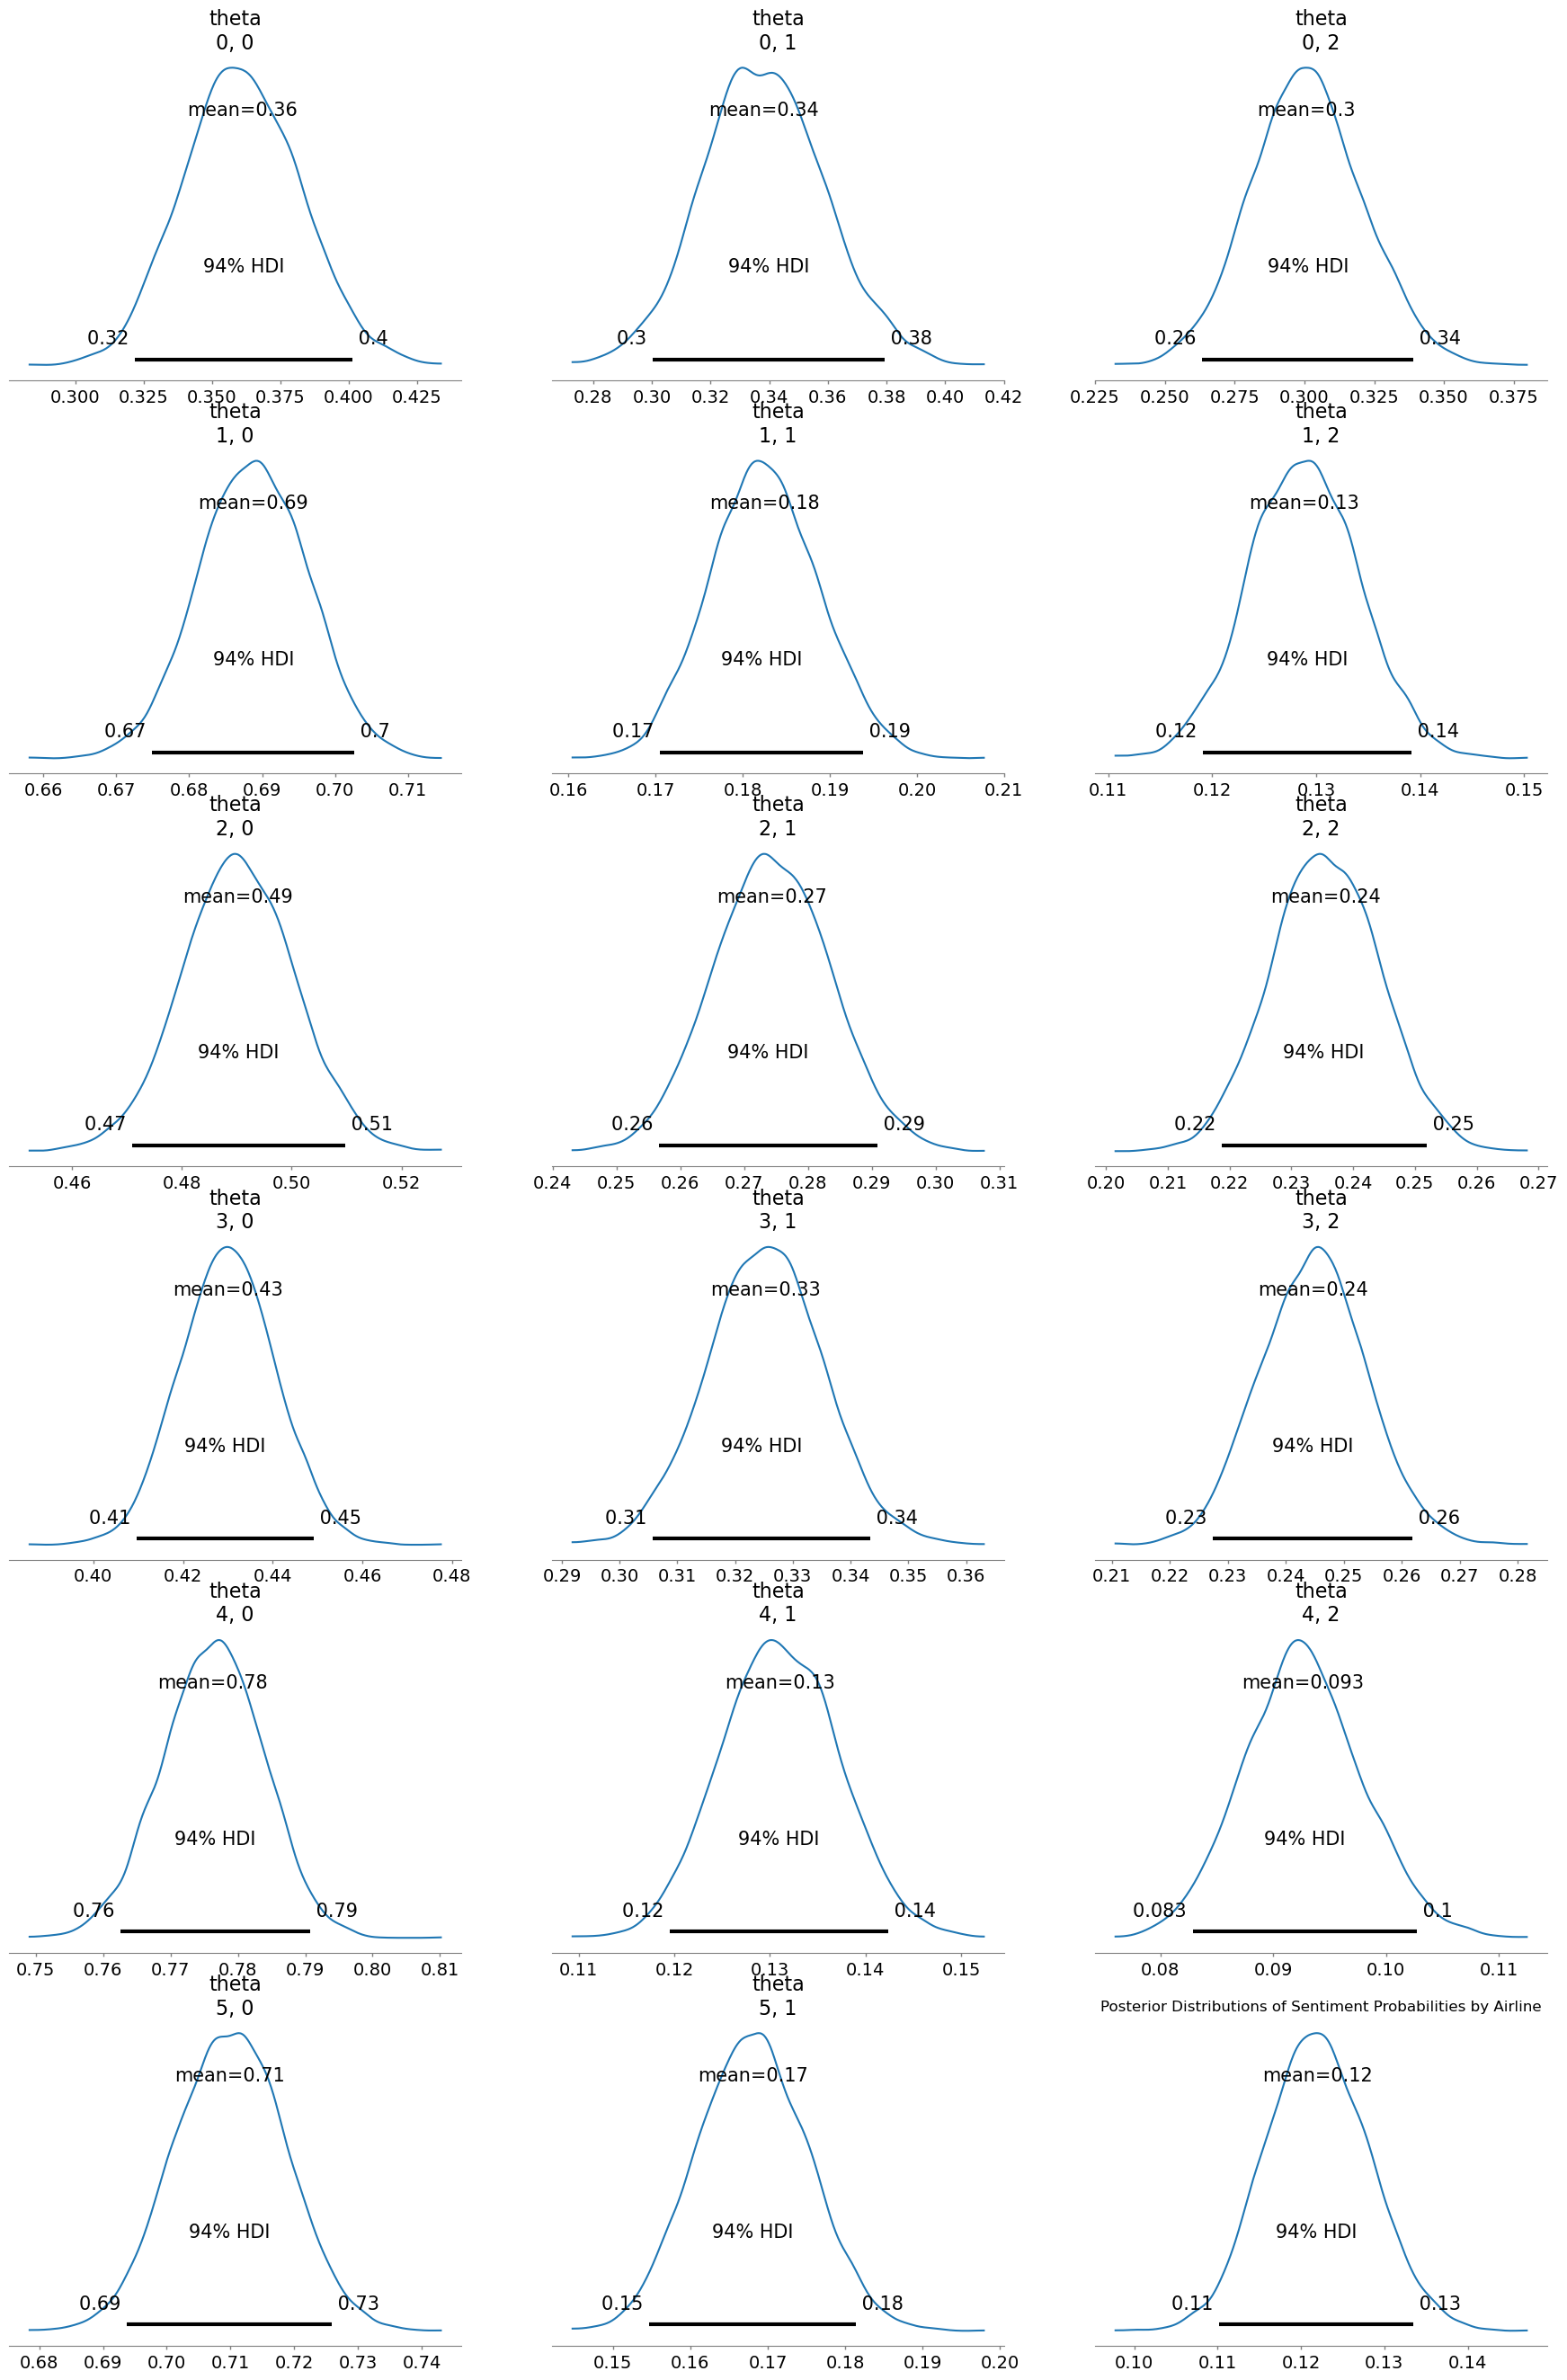

Available parameters in trace:
['theta[0, 0]', 'theta[0, 1]', 'theta[0, 2]', 'theta[1, 0]', 'theta[1, 1]']


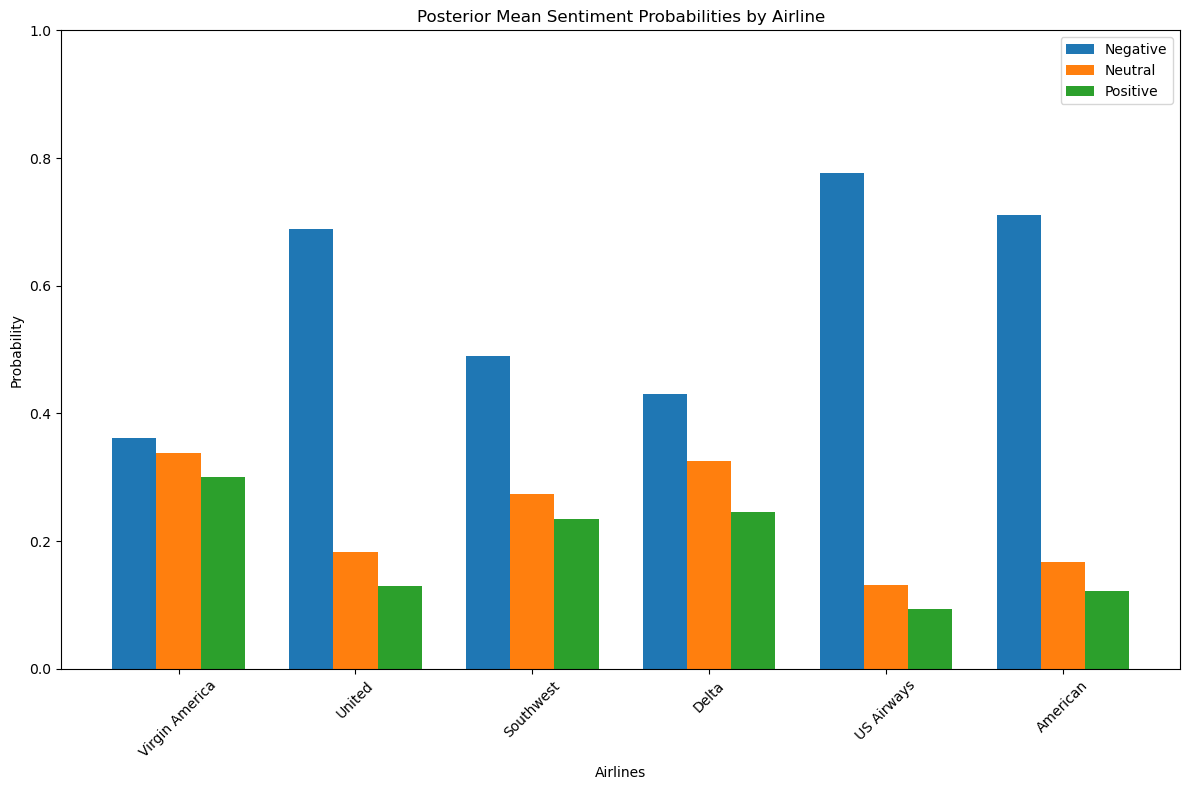

In [17]:
# Hierarchical Bayesian Model

# Define the hierarchical model
with pm.Model() as hierarchical_model:
    # Hyperpriors for the population-level sentiment distribution
    alpha_population = pm.Dirichlet('alpha_population', a=np.ones(3))
    
    # Concentration parameter for airline-specific distributions
    concentration = pm.Gamma('concentration', alpha=2, beta=1)
    
    # Airline-specific sentiment distributions
    theta = pm.Dirichlet('theta',
                         a=(alpha_population * concentration)[None, :],
                         shape=(len(airlines), 3))
    
    # Observations for each airline
    for i, airline in enumerate(airlines):
        pm.Categorical(f'obs_{airline}',
                       p=theta[i],
                       observed=np.repeat([0, 1, 2], 
                                          airline_data[airline]['counts']))

    # Sample from posterior
    hierarchical_trace = pm.sample(2000, tune=1000, return_inferencedata=True)

# Plot results
az.plot_posterior(hierarchical_trace, var_names=['theta'])
plt.title('Posterior Distributions of Sentiment Probabilities by Airline')
plt.show()

# Add visualization of differences between airlines
def plot_sentiment_comparisons(hierarchical_trace, airlines):
    plt.figure(figsize=(12, 8))
    
    # Extract posterior means for each airline
    posterior_means = az.summary(hierarchical_trace, var_names=['theta'])
    
    # Create sentiment comparison plot
    sentiment_labels = ['Negative', 'Neutral', 'Positive']
    x = np.arange(len(airlines))
    width = 0.25

    for i, sentiment in enumerate(sentiment_labels):
        values = []
        for j in range(len(airlines)):
            # Correct index format for accessing posterior means
            key = f'theta[{j}, {i}]'
            values.append(posterior_means.loc[key, 'mean'])

        plt.bar(x + i*width, values, width, label=sentiment)

    plt.xlabel('Airlines')
    plt.ylabel('Probability')
    plt.ylim(0, 1)
    plt.title('Posterior Mean Sentiment Probabilities by Airline')
    plt.xticks(x + width, airlines, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
# Let's verify the structure of the posterior summary first
print("Available parameters in trace:")
print(az.summary(hierarchical_trace, var_names=['theta']).index.tolist()[:5])  # Show first 5 indices

# Now plot
plot_sentiment_comparisons(hierarchical_trace, airlines)

## Model Comparison and Evaluation

Compare the models using appropriate metrics, visualize results, and draw conclusions about airline sentiment patterns. Include uncertainty quantification and interpretation.

A forest plot shows the posterior distributions for each parameter (theta) in both models:

- Each horizontal line represents a 95% credible interval
- The point in the middle represents the posterior mean
- Narrower intervals indicate more certainty in the estimate
- The hierarchical model shows separate estimates for each airline, while the basic model shows overall sentiment probabilities

This plot shows the mean estimates (dots) and 95% credible intervals (horizontal lines) for:

- Basic Model: Overall sentiment probabilities
- Hierarchical Model: Airline-specific sentiment probabilities


Basic Model Summary:
           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0]  0.627  0.004   0.620    0.634        0.0      0.0    6726.0   
theta[1]  0.212  0.003   0.206    0.218        0.0      0.0    6601.0   
theta[2]  0.161  0.003   0.156    0.167        0.0      0.0    6787.0   

          ess_tail  r_hat  
theta[0]    5389.0    1.0  
theta[1]    5580.0    1.0  
theta[2]    5795.0    1.0  

Hierarchical Model Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
theta[0, 0]  0.361  0.021   0.322    0.401        0.0      0.0   11823.0   
theta[0, 1]  0.338  0.021   0.300    0.379        0.0      0.0   13829.0   
theta[0, 2]  0.301  0.020   0.263    0.339        0.0      0.0   12134.0   
theta[1, 0]  0.689  0.007   0.675    0.703        0.0      0.0   15257.0   
theta[1, 1]  0.183  0.006   0.170    0.194        0.0      0.0   14170.0   
theta[1, 2]  0.129  0.005   0.119    0.139        0.0      0.0   15212.0   
theta[2, 0]  

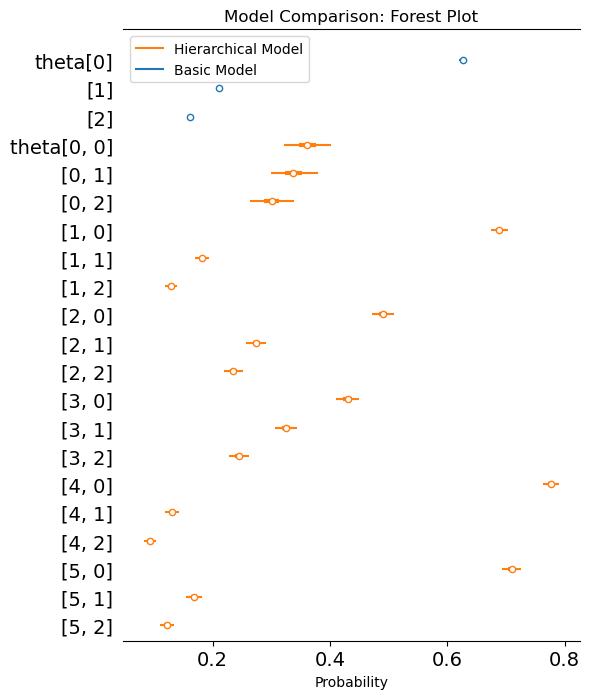

Basic Model HDI:
<xarray.Dataset> Size: 120B
Dimensions:      (theta_dim_0: 3, hdi: 2)
Coordinates:
  * theta_dim_0  (theta_dim_0) int64 24B 0 1 2
  * hdi          (hdi) <U6 48B 'lower' 'higher'
Data variables:
    theta        (theta_dim_0, hdi) float64 48B 0.6195 0.6349 ... 0.1556 0.1674

Hierarchical Model HDI:
<xarray.Dataset> Size: 496B
Dimensions:                 (alpha_population_dim_0: 3, hdi: 2, theta_dim_0: 6,
                             theta_dim_1: 3)
Coordinates:
  * alpha_population_dim_0  (alpha_population_dim_0) int64 24B 0 1 2
  * theta_dim_0             (theta_dim_0) int64 48B 0 1 2 3 4 5
  * theta_dim_1             (theta_dim_1) int64 24B 0 1 2
  * hdi                     (hdi) <U6 48B 'lower' 'higher'
Data variables:
    alpha_population        (alpha_population_dim_0, hdi) float64 48B 0.3636 ...
    concentration           (hdi) float64 16B 2.338 9.838
    theta                   (theta_dim_0, theta_dim_1, hdi) float64 288B 0.32...


In [38]:
# Compare the models using appropriate metrics
basic_model_summary = az.summary(basic_trace, var_names=["theta"])
hierarchical_model_summary = az.summary(hierarchical_trace, var_names=["theta"])

# Print summaries for comparison
print("Basic Model Summary:")
print(basic_model_summary)

print("\nHierarchical Model Summary:")
print(hierarchical_model_summary)

# Forest plot with improved labels
az.plot_forest(
    [basic_trace, hierarchical_trace],
    model_names=["Basic Model", "Hierarchical Model"],
    var_names=["theta"],
    combined=True  # This combines the chains into a single summary
)
plt.title("Model Comparison: Forest Plot")
plt.xlabel("Probability")
plt.tight_layout()
plt.show()

# Uncertainty quantification and interpretation
basic_model_hdi = az.hdi(basic_trace, hdi_prob=0.95)
hierarchical_model_hdi = az.hdi(hierarchical_trace, hdi_prob=0.95)

print("Basic Model HDI:")
print(basic_model_hdi)

print("\nHierarchical Model HDI:")
print(hierarchical_model_hdi)

### Model Comparison Visualization

The plots below show:

1. **Basic Model**: Overall sentiment probabilities across all airlines
1. **Hierarchical Model**: Airline-specific sentiment probabilities

The posterior distributions show the probability ranges for each sentiment category, with wider distributions indicating more uncertainty in the estimates.

Basic Model Variables:
Frozen({'chain': <xarray.IndexVariable 'chain' (chain: 4)> Size: 32B
array([0, 1, 2, 3]), 'draw': <xarray.IndexVariable 'draw' (draw: 2000)> Size: 16kB
array([   0,    1,    2, ..., 1997, 1998, 1999]), 'theta_dim_0': <xarray.IndexVariable 'theta_dim_0' (theta_dim_0: 3)> Size: 24B
array([0, 1, 2]), 'theta': <xarray.Variable (chain: 4, draw: 2000, theta_dim_0: 3)> Size: 192kB
array([[[0.63762583, 0.20759527, 0.1547789 ],
        [0.62278043, 0.2117851 , 0.16543447],
        [0.6282978 , 0.21185804, 0.15984415],
        ...,
        [0.62259612, 0.21356136, 0.16384253],
        [0.62670148, 0.21213057, 0.16116795],
        [0.62355405, 0.21621767, 0.16022828]],

       [[0.61844806, 0.22027775, 0.16127419],
        [0.62683954, 0.21154034, 0.16162012],
        [0.62989413, 0.21273947, 0.1573664 ],
        ...,
        [0.63123921, 0.21129886, 0.15746193],
        [0.62600122, 0.21422523, 0.15977355],
        [0.62427855, 0.21215903, 0.16356241]],

       [[0.6258017

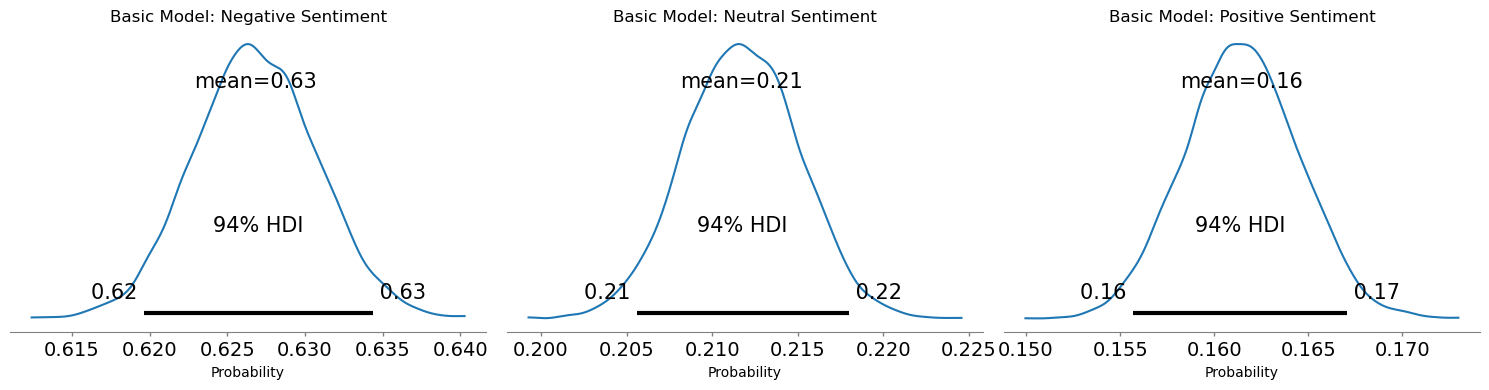

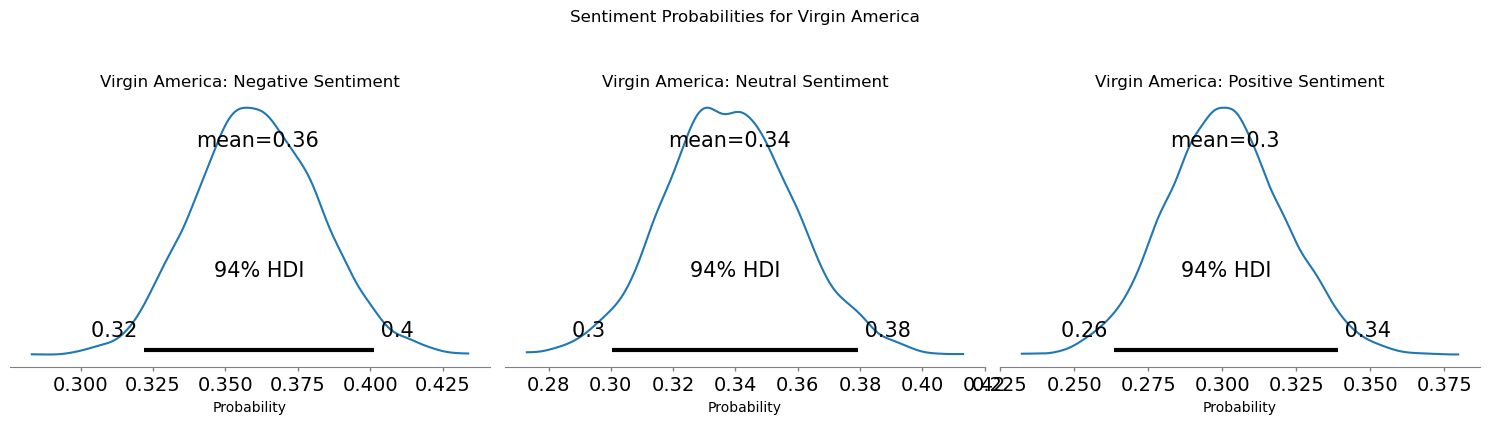

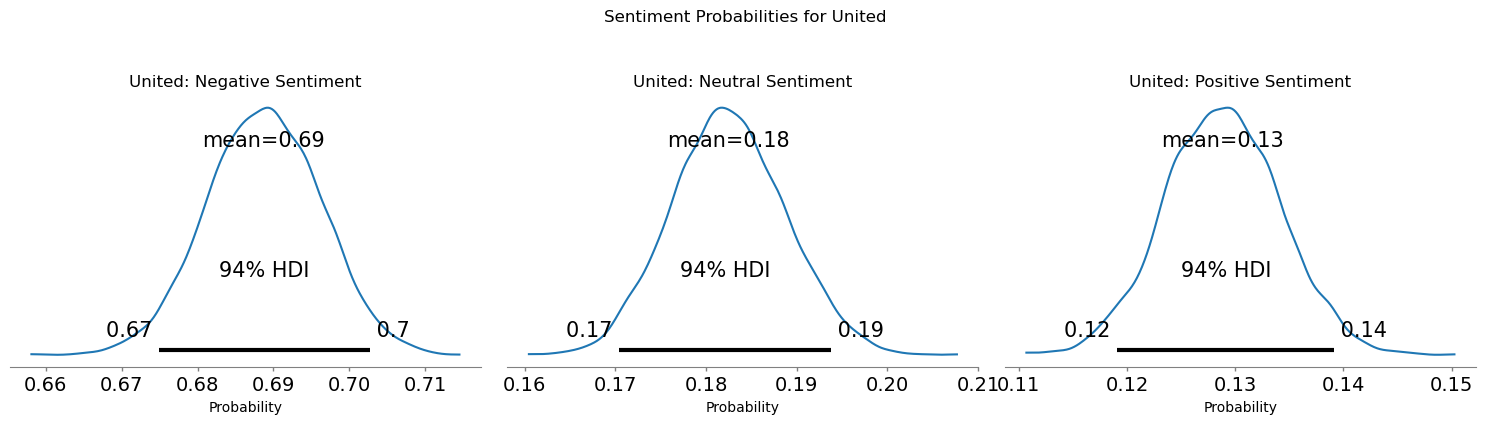

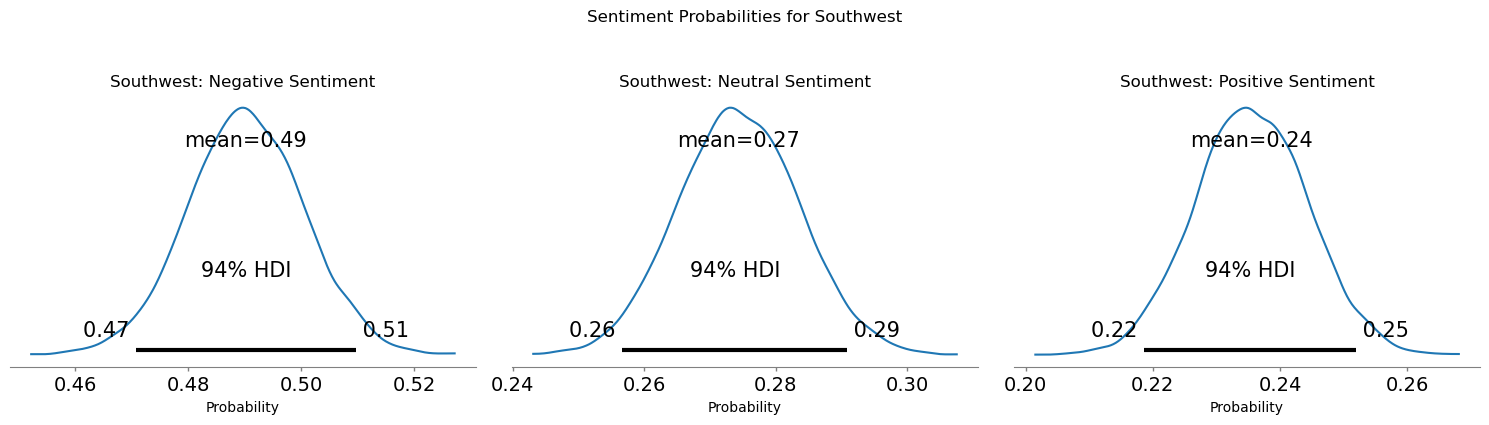

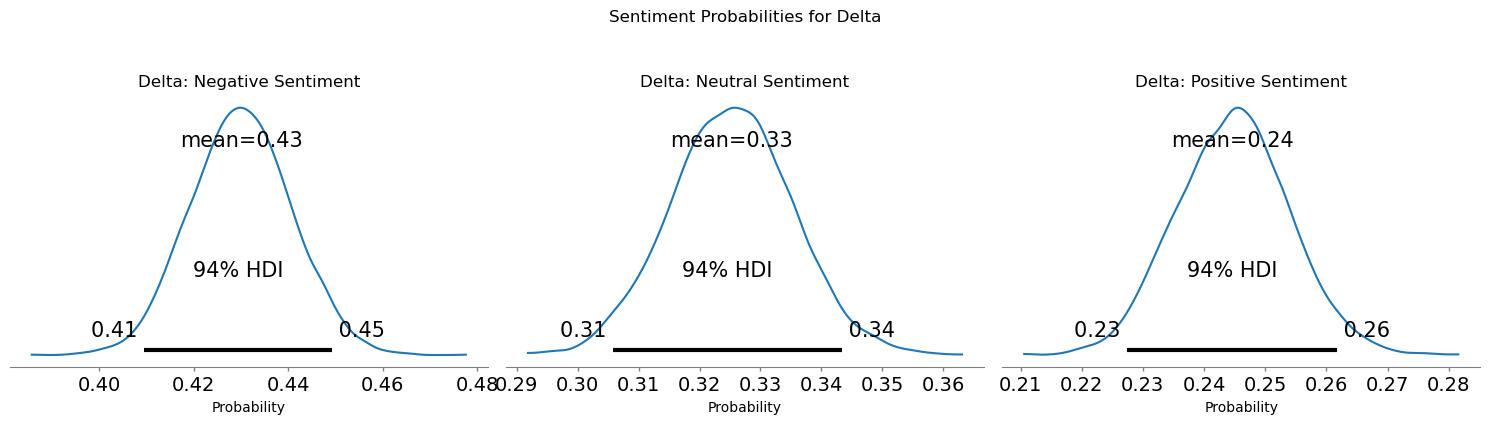

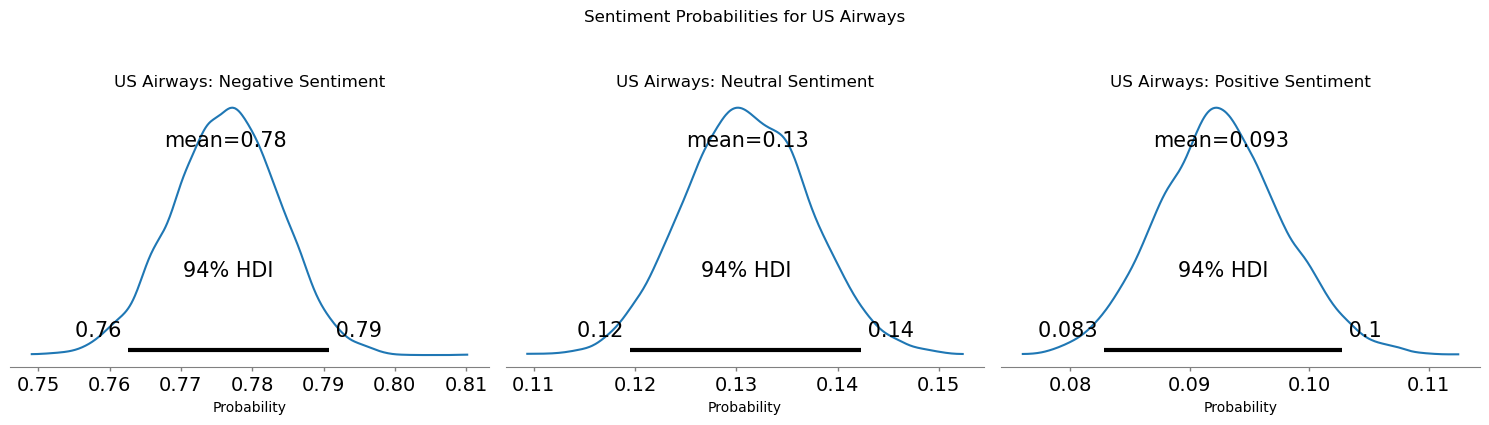

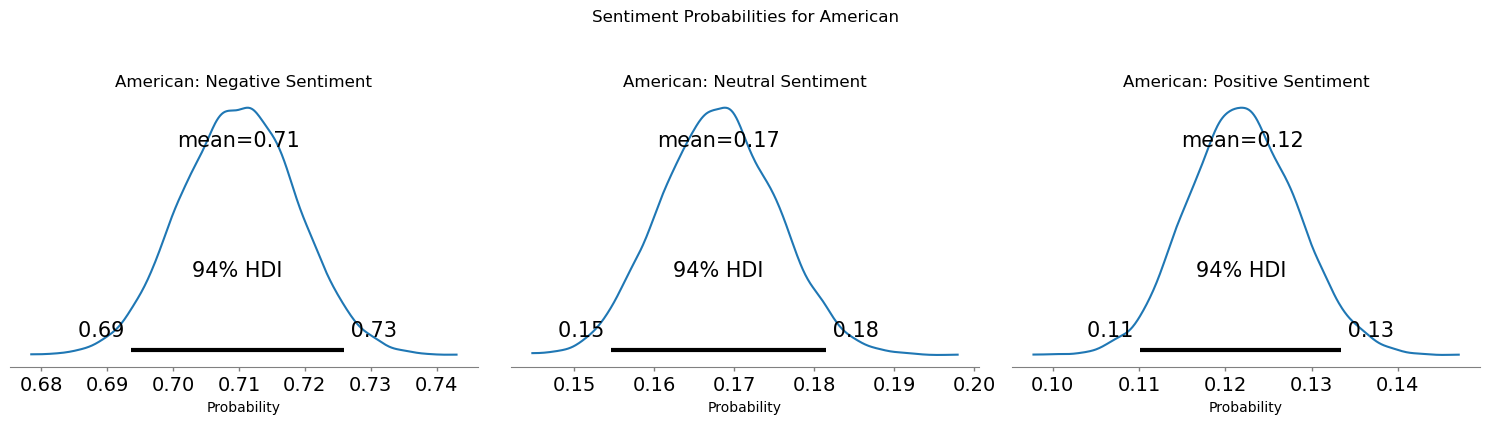

In [ ]:
# Create meaningful labels
sentiment_labels = ['Negative', 'Neutral', 'Positive']
airline_labels = df['airline'].unique()

# print("Basic Model Variables:")
# print(basic_trace.posterior.variables)

# print("\nHierarchical Model Variables:")
# print(hierarchical_trace.posterior.variables)

# Basic Model Plots
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
for i, sentiment in enumerate(sentiment_labels):
    az.plot_posterior(basic_trace, 
                     var_names="theta", 
                     coords={'theta_dim_0': i}, 
                     ax=axs[i])
    axs[i].set_title(f"Basic Model: {sentiment} Sentiment")
    axs[i].set_xlabel("Probability")

plt.tight_layout()
plt.show()

# Hierarchical Model Plots - one plot per airline
for airline_idx, airline in enumerate(airline_labels):
    fig, axs = plt.subplots(1, 3, figsize=(15, 4))
    
    for sent_idx, sentiment in enumerate(sentiment_labels):
        az.plot_posterior(hierarchical_trace, 
                         var_names="theta", 
                         coords={'theta_dim_0': airline_idx,
                                'theta_dim_1': sent_idx},
                         ax=axs[sent_idx])
        axs[sent_idx].set_title(f"{airline}: {sentiment} Sentiment")
        axs[sent_idx].set_xlabel("Probability")
    
    plt.suptitle(f"Sentiment Probabilities for {airline}", y=1.05)
    plt.tight_layout()
    plt.show()

In [ ]:
# 